# Generating radio signals

In [2]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
from IPython.display import Audio

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# Amplitude modulation

First, we need to figure out how to modulate the amplitude of the carrier wave to "high amplitude" and "low amplitude" to correspond with the binary"s and 0s.

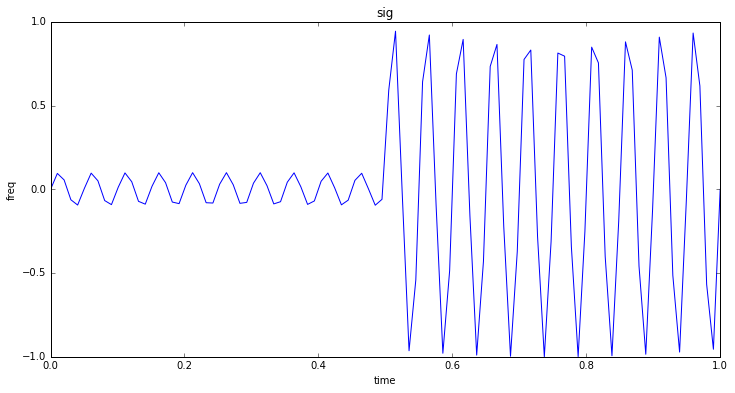

In [3]:
samp_rate = 100
len_in_sec = 1
carrier_freq = 20

low_amp = 0.1
high_amp = 1

t = np.linspace(0, 1, samp_rate * len_in_sec)
carrier = 1*np.sin(carrier_freq * 2 * np.pi * t)

# Modulate with the binary signal: ['0', '1']
amp_mult = np.array([low_amp]*50 + [high_amp]*50)
sig = amp_mult * carrier

setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(12,6))
plt.plot(t, sig)

So looking at the above example, let's see how we calculate the size of the multiplier array...

The carrier frequency is 20Hz. The baud, in this case, is 2 bits per second, which is why we need 1 second to contain the 2 bits. The size of the multiplier wave to modulate the carrier wave is 50 in size, because with a sample rate of 100 samples per second, and 2 bits per second, samples_per_bit = 100 / 2 = 50.

## Write function to modulate amplitude according to binary data

[ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]


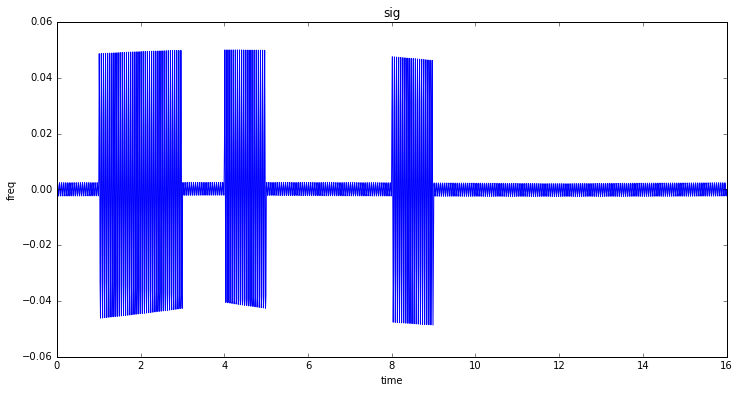

In [8]:
DEFAULT_RATIOS = {
    '_': 1,
    '0': 1,
    '1': 3
}

def generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate, baud, sig_ratios=DEFAULT_RATIOS):
    low_amplitude = 0.05
    high_amplitude = 1
    
    digit_to_amp = {'0': low_amplitude, '1': high_amplitude}
    
    signal_len_secs = len(binary_data) * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    carrier_wave = low_amplitude * np.sin(carrier_wave_freq * 2 * np.pi * t)
    bit_sample_size = int(sample_rate * (1/baud))
    modulation_array = [[digit_to_amp[bit]]*bit_sample_size for bit in binary_data]
    modulation_array_flat = np.array([], dtype=np.int16)
    for a in modulation_array:
        modulation_array_flat = np.append(modulation_array_flat, a)
    print(modulation_array_flat)
    return t, carrier_wave * modulation_array_flat
    

binary_data = '0110100010000000'
carrier_wave_freq = 20 #315e6
sample_rate = 100
baud = 1

t, sig = generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate, baud)
setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(12,6))
plt.plot(t, sig)

In [ ]:
SAMPLE_BITSIZE = 16
MAX_AMP_16BIT = int(2**SAMPLE_BITSIZE/2 - 1)

def generate_wave(freq, len_in_sec=1, samp_rate=44100, amplitude=MAX_AMP_16BIT):
    t = np.linspace(0, len_in_sec, samp_rate * len_in_sec)
    sig = amplitude * np.sin(freq * 2 * np.pi * t) 
    return sig

def write_wav_file(file_path, wav_data, sample_rate=44100, num_channels=1):
    f = wave.open(file_path, 'wb')
    f.setparams((num_channels, 2, sample_rate, len(wav_data), "NONE", "Uncompressed"))
    f.writeframes(np.array(wav_data, dtype=np.int16))
    f.close()